In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
import sys 
sys.path.append("..") 
%aimport p2v

In [4]:
import pandas as pd
import numpy as np
import os

pd.options.display.max_columns = None
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', 50)

from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle, FancyArrowPatch
import matplotlib.patheffects as path_effects
from matplotlib.ticker import MultipleLocator
import mpltern
from adjustText import adjust_text 

In [5]:
model = p2v.P2V()

2023-09-21 18:59:59 -- start loading Mag_venue_info_df
2023-09-21 19:00:00 -- finish.
2023-09-21 19:00:00 -- start loading labeled_journal_info_df
2023-09-21 19:00:00 -- finish.


In [6]:
def make_ternary_df(start_year, end_year):
    model.load_wv(start_year, end_year, 100, 10)
    VIDs = model.wv.index_to_key
    vectors = model.wv.get_normed_vectors()
    
    ternary_df = pd.DataFrame(list(zip(VIDs, vectors)), columns =['VID', 'vector'])
    VID_labeled = model.load_VID_labeled(start_year, end_year, 100, 10)
    ternary_df = ternary_df.loc[ternary_df.VID.isin(VID_labeled['VID'])]
    ternary_df['label'] = VID_labeled['label']
    
    ternary_df.loc[:,'venue_name'] = ternary_df['VID'].apply(lambda x: model.MAG_venue_info_df.at[x, 'OriginalVenue'])

    ternary_df.loc[ternary_df.label.isin(['Agricultural and Biological Sciences', 
                                          'Biochemistry, Genetics and Molecular Biology', 
                                          'Immunology and Microbiology', 
                                          'Neuroscience', 
                                          'Pharmacology, Toxicology and Pharmaceutics']), 'area'] = 'Life Science'
    ternary_df.loc[ternary_df.label.isin(['Medicine', 
                                          'Nursing',
                                          'Veterinary',
                                          'Dentistry',
                                          'Health Professions']), 'area'] = 'Health Science'
    ternary_df.loc[ternary_df.label.isin(['Chemical Engineering',
                                          'Chemistry',
                                          'Computer Science',
                                          'Earth and Planetary Sciences',
                                          'Energy',
                                          'Engineering',
                                          'Environmental Science',
                                          'Material Science',
                                          'Mathematics',
                                          'Physics and Astronomy']), 'area'] = 'Physical Science'
    ternary_df.loc[ternary_df.label.isin(['Arts and Humanities',
                                          'Business, Management and Accounting',
                                          'Decision Sciences',
                                          'Economics, Econometrics and Finance',
                                          'Psychology',
                                          'Social Sciences']), 'area'] = 'Social Science'
    ternary_df.loc[ternary_df.label=='Multidisciplinary', 'area'] = 'Multidisciplinary'
    
    pole_life = ternary_df[ternary_df.area == 'Life Science'].vector.mean()
    pole_health = ternary_df[ternary_df.area == 'Health Science'].vector.mean()
    pole_physical = ternary_df[ternary_df.area == 'Physical Science'].vector.mean()
    
    ternary_df['life_cs'] = ternary_df.vector.apply(lambda x: 
                                                    cosine_similarity(x.reshape(1, -1), pole_life.reshape(1, -1))[0][0])
    ternary_df['health_cs'] = ternary_df.vector.apply(lambda x: 
                                                      cosine_similarity(x.reshape(1, -1), pole_health.reshape(1, -1))[0][0])
    ternary_df['physical_cs'] = ternary_df.vector.apply(lambda x: 
                                                        cosine_similarity(x.reshape(1, -1), pole_physical.reshape(1, -1))[0][0])

    
    ternary_df[['life_cs', 'health_cs', 'physical_cs']] = ternary_df[['life_cs', 'health_cs', 'physical_cs']].apply(lambda x: (x-x.min())/(x.max()-x.min()))
    ternary_df.drop(columns=['vector'], inplace=True)
    
    return ternary_df

In [7]:
life_color = '#0099FF'
health_color = '#CC00FF'
physical_color = '#FC9320'
social_color = '#16A90F'
multi_color = '#000000'

arrowstyle = ArrowStyle('simple', head_length=10, head_width=5)

2023-09-07 10:32:34 -- start loading word vectors...
2023-09-07 10:32:34 -- word vectors loaded, and its shape is: (1683, 100)
2023-09-07 10:32:34 -- start loading VID_labeled...
2023-09-07 10:32:34 -- finish.
2023-09-07 10:32:35 -- start loading word vectors...
2023-09-07 10:32:35 -- word vectors loaded, and its shape is: (3186, 100)
2023-09-07 10:32:35 -- start loading VID_labeled...
2023-09-07 10:32:35 -- finish.
2023-09-07 10:32:36 -- start loading word vectors...
2023-09-07 10:32:36 -- word vectors loaded, and its shape is: (5761, 100)
2023-09-07 10:32:36 -- start loading VID_labeled...
2023-09-07 10:32:36 -- finish.
2023-09-07 10:32:38 -- start loading word vectors...
2023-09-07 10:32:38 -- word vectors loaded, and its shape is: (9437, 100)
2023-09-07 10:32:38 -- start loading VID_labeled...
2023-09-07 10:32:38 -- finish.
2023-09-07 10:32:41 -- start loading word vectors...
2023-09-07 10:32:41 -- word vectors loaded, and its shape is: (15153, 100)
2023-09-07 10:32:41 -- start loa

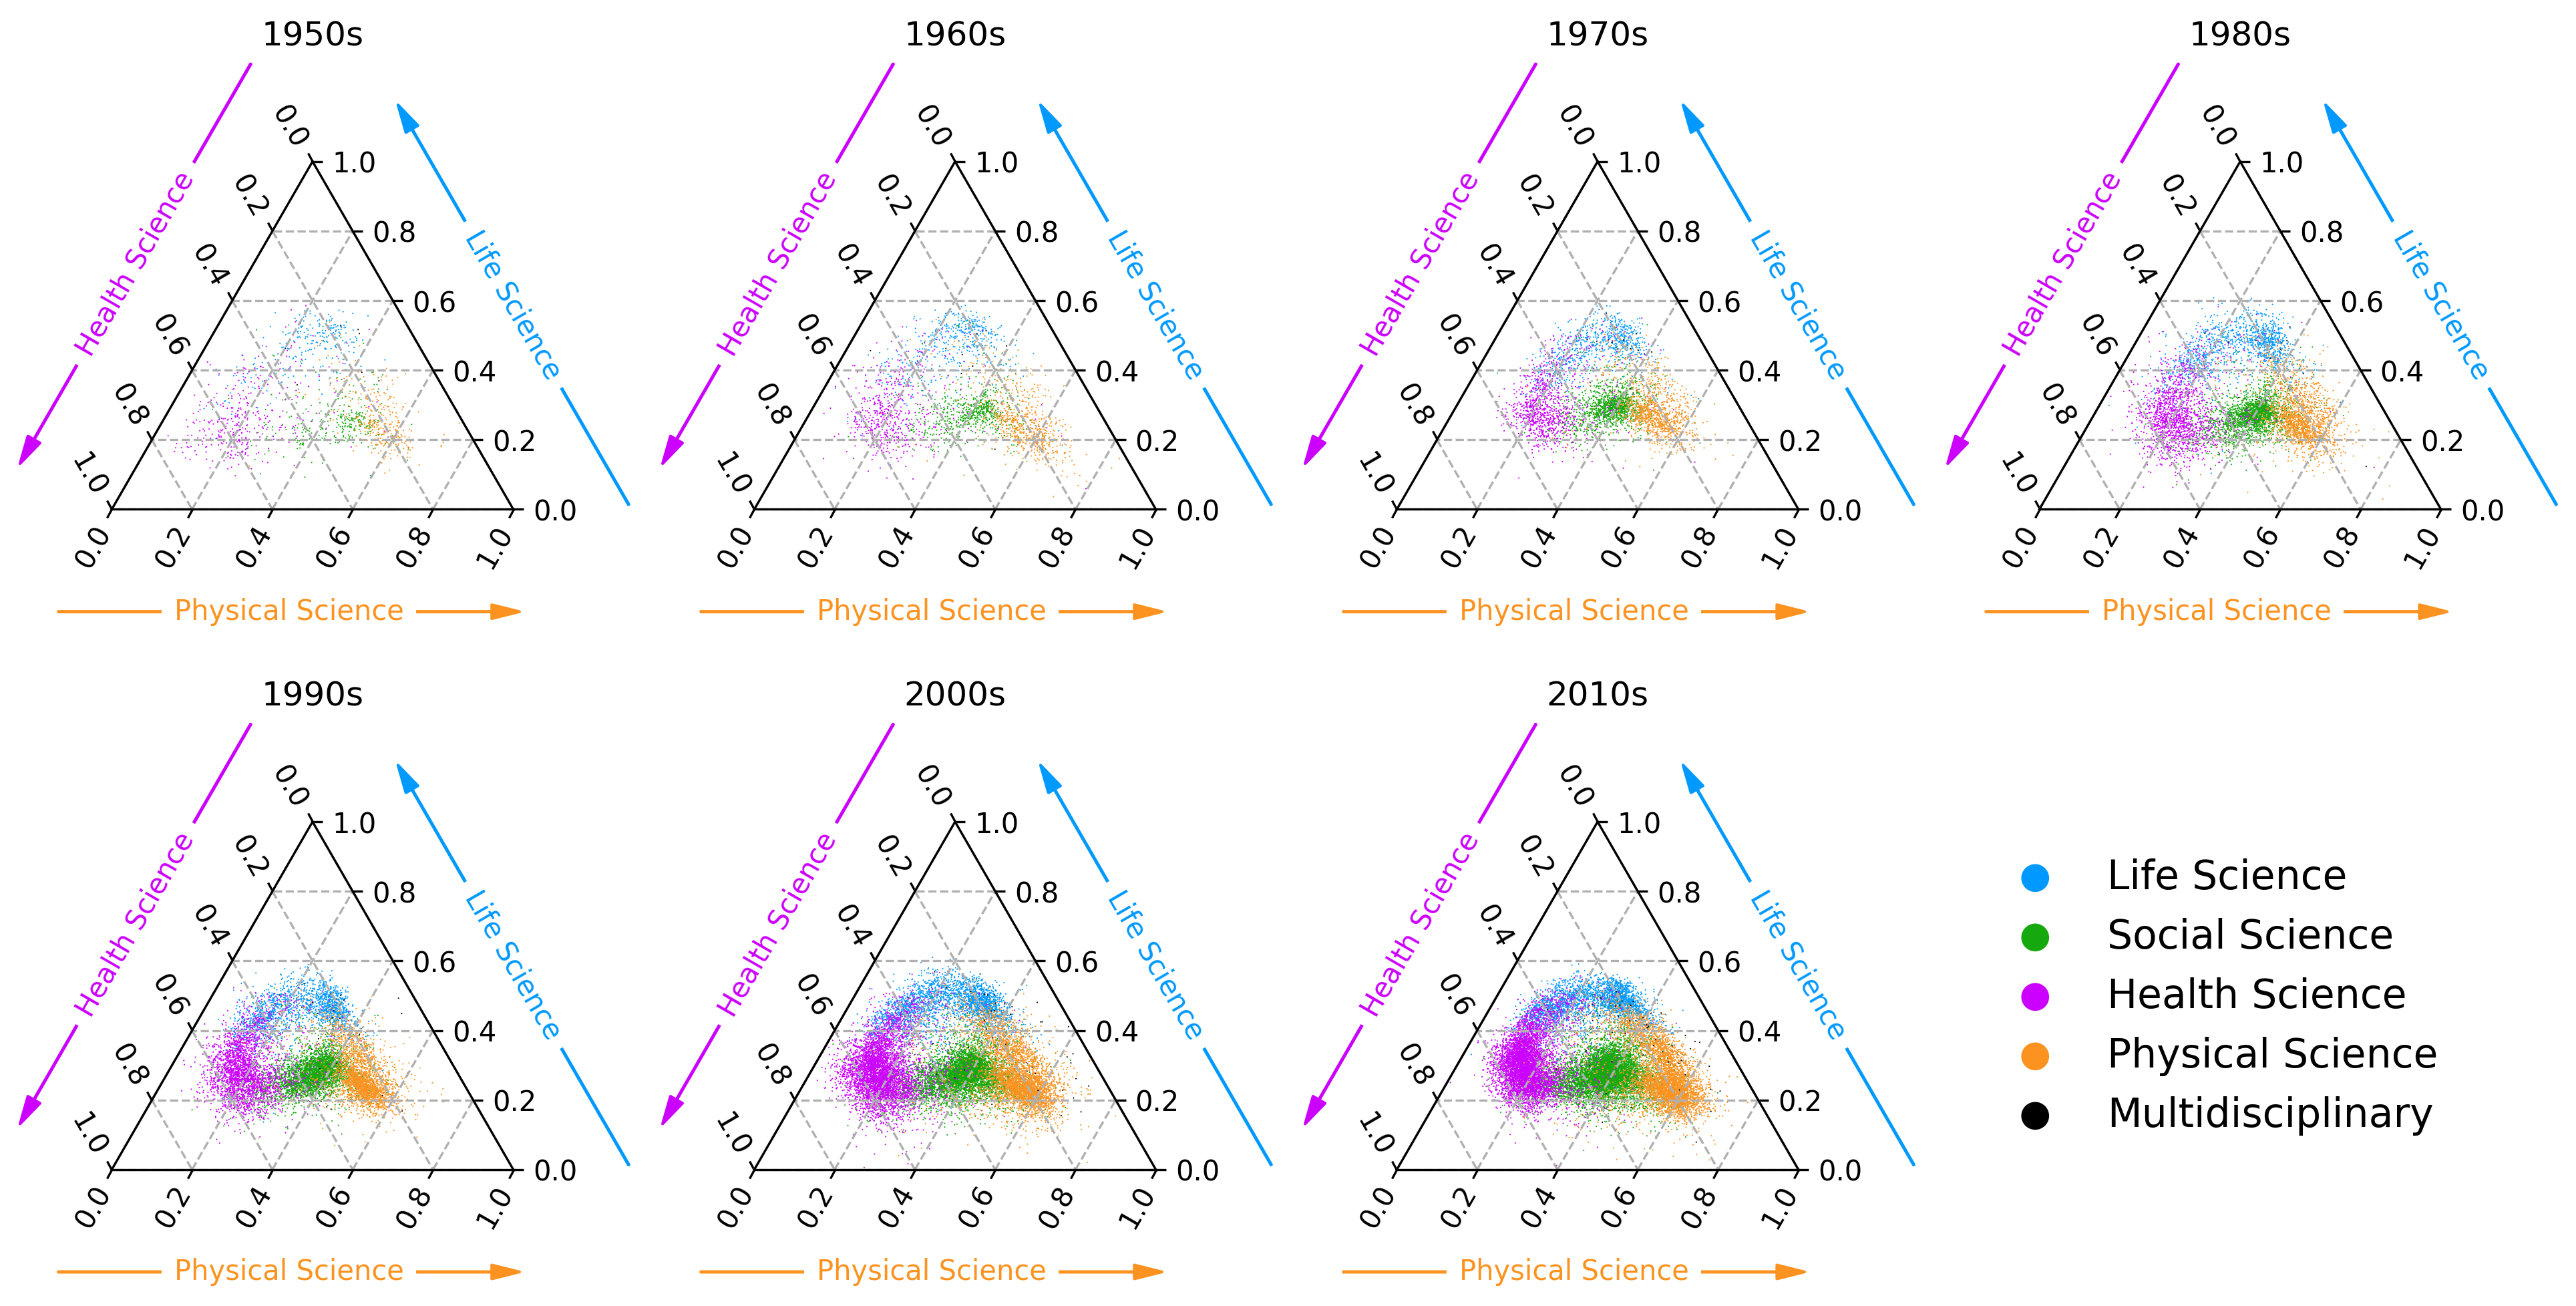

In [46]:
fig = plt.figure(figsize=(15, 8), dpi=300)
fig.subplots_adjust(wspace=0.6)

area_color_dict = {'Life Science': '#0099FF',
                   'Health Science': '#CC00FF',
                   'Physical Science': '#FC9320',
                   'Social Science': '#16A90F',
                   'Multidisciplinary': '#000000'}

for i in range(len(model.start_year_list)-7, len(model.start_year_list)):
    ax = fig.add_subplot(2, 4, i -14, projection='ternary')
    
    kwargs_label = {
        'transform': ax.transTernaryAxes,
        'backgroundcolor': 'w',
        'ha': 'center',
        'va': 'center',
        'rotation_mode': 'anchor',
        'zorder': -9,  # A bit higher on arrows, but still lower than others.
    }
    
    # Start of arrows in barycentric coordinates.
    ta = np.array([ 0.0, -0.25,  1.1])
    la = np.array([ 1.1,  0.0, -0.25])
    ra = np.array([-0.25,  1.1,  0.0])
    
    # End of arrows in barycentric coordinates.
    tb = np.array([ 1.0, -0.25,  0.1])
    lb = np.array([ 0.1,  1.0, -0.25])
    rb = np.array([-0.25,  0.1,  1.0])
    
    f = ax.transAxesProjection.transform

    kwargs_arrow = {
    'transform': ax.transAxes,  # Used with ``ax.transAxesProjection``
    'arrowstyle': arrowstyle,
    'linewidth': 1,
    'clip_on': False,  # To plot arrows outside triangle
    'zorder': -10,  # Very low value not to hide e.g. tick labels.
    }

    tarrow = FancyArrowPatch(f(ta), f(tb), ec=life_color, fc=life_color, **kwargs_arrow)
    larrow = FancyArrowPatch(f(la), f(lb), ec=health_color, fc=health_color, **kwargs_arrow)
    rarrow = FancyArrowPatch(f(ra), f(rb), ec=physical_color, fc=physical_color, **kwargs_arrow)
    
    ax.add_patch(tarrow)
    ax.add_patch(larrow)
    ax.add_patch(rarrow)

    tpos = (ta + tb) * 0.5
    lpos = (la + lb) * 0.5
    rpos = (ra + rb) * 0.5
    
    ax.text(*tpos, 'Life Science'  , color=life_color, rotation=-60, **kwargs_label)
    ax.text(*lpos, 'Health Science' , color=health_color, rotation=60, **kwargs_label)
    ax.text(*rpos, 'Physical Science', color=physical_color, rotation=0, **kwargs_label)
    
    ax.grid(linestyle='--')

    start_year, end_year = model.start_year_list[i], model.end_year_list[i]
    ternary_df = make_ternary_df(start_year, end_year)

    for area in ['Life Science', 'Social Science', 'Health Science', 'Physical Science', 'Multidisciplinary']:
        tar_df = ternary_df[ternary_df.area == area]
        t, l, r = tar_df.life_cs, tar_df.health_cs, tar_df.physical_cs
        ax.scatter(t, l, r, label=area, marker='.', s=1, color=area_color_dict[area], edgecolors='none', alpha=1)

    ax.set_title(start_year+'s', pad=20)
ax.legend(markerscale=20, fontsize='x-large', edgecolor='white', bbox_to_anchor=(1.40, 0.40, 0.6, 0.6))
plt.show()

In [47]:
dirs = '/media/sdb/p2v/figs/'
if not os.path.exists(dirs):
    os.makedirs(dirs)
fig.savefig('/media/sdb/p2v/figs/7_decades_ternary_plot.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

2023-09-21 19:00:24 -- start loading word vectors...
2023-09-21 19:00:24 -- word vectors loaded, and its shape is: (1645, 100)
2023-09-21 19:00:24 -- start loading VID_labeled...
2023-09-21 19:00:24 -- finish.
2023-09-21 19:00:24 -- start loading word vectors...
2023-09-21 19:00:24 -- word vectors loaded, and its shape is: (3116, 100)
2023-09-21 19:00:24 -- start loading VID_labeled...
2023-09-21 19:00:24 -- finish.
2023-09-21 19:00:26 -- start loading word vectors...
2023-09-21 19:00:26 -- word vectors loaded, and its shape is: (5686, 100)
2023-09-21 19:00:26 -- start loading VID_labeled...
2023-09-21 19:00:26 -- finish.
2023-09-21 19:00:28 -- start loading word vectors...
2023-09-21 19:00:28 -- word vectors loaded, and its shape is: (9337, 100)
2023-09-21 19:00:28 -- start loading VID_labeled...
2023-09-21 19:00:28 -- finish.
2023-09-21 19:00:31 -- start loading word vectors...
2023-09-21 19:00:31 -- word vectors loaded, and its shape is: (15019, 100)
2023-09-21 19:00:31 -- start loa

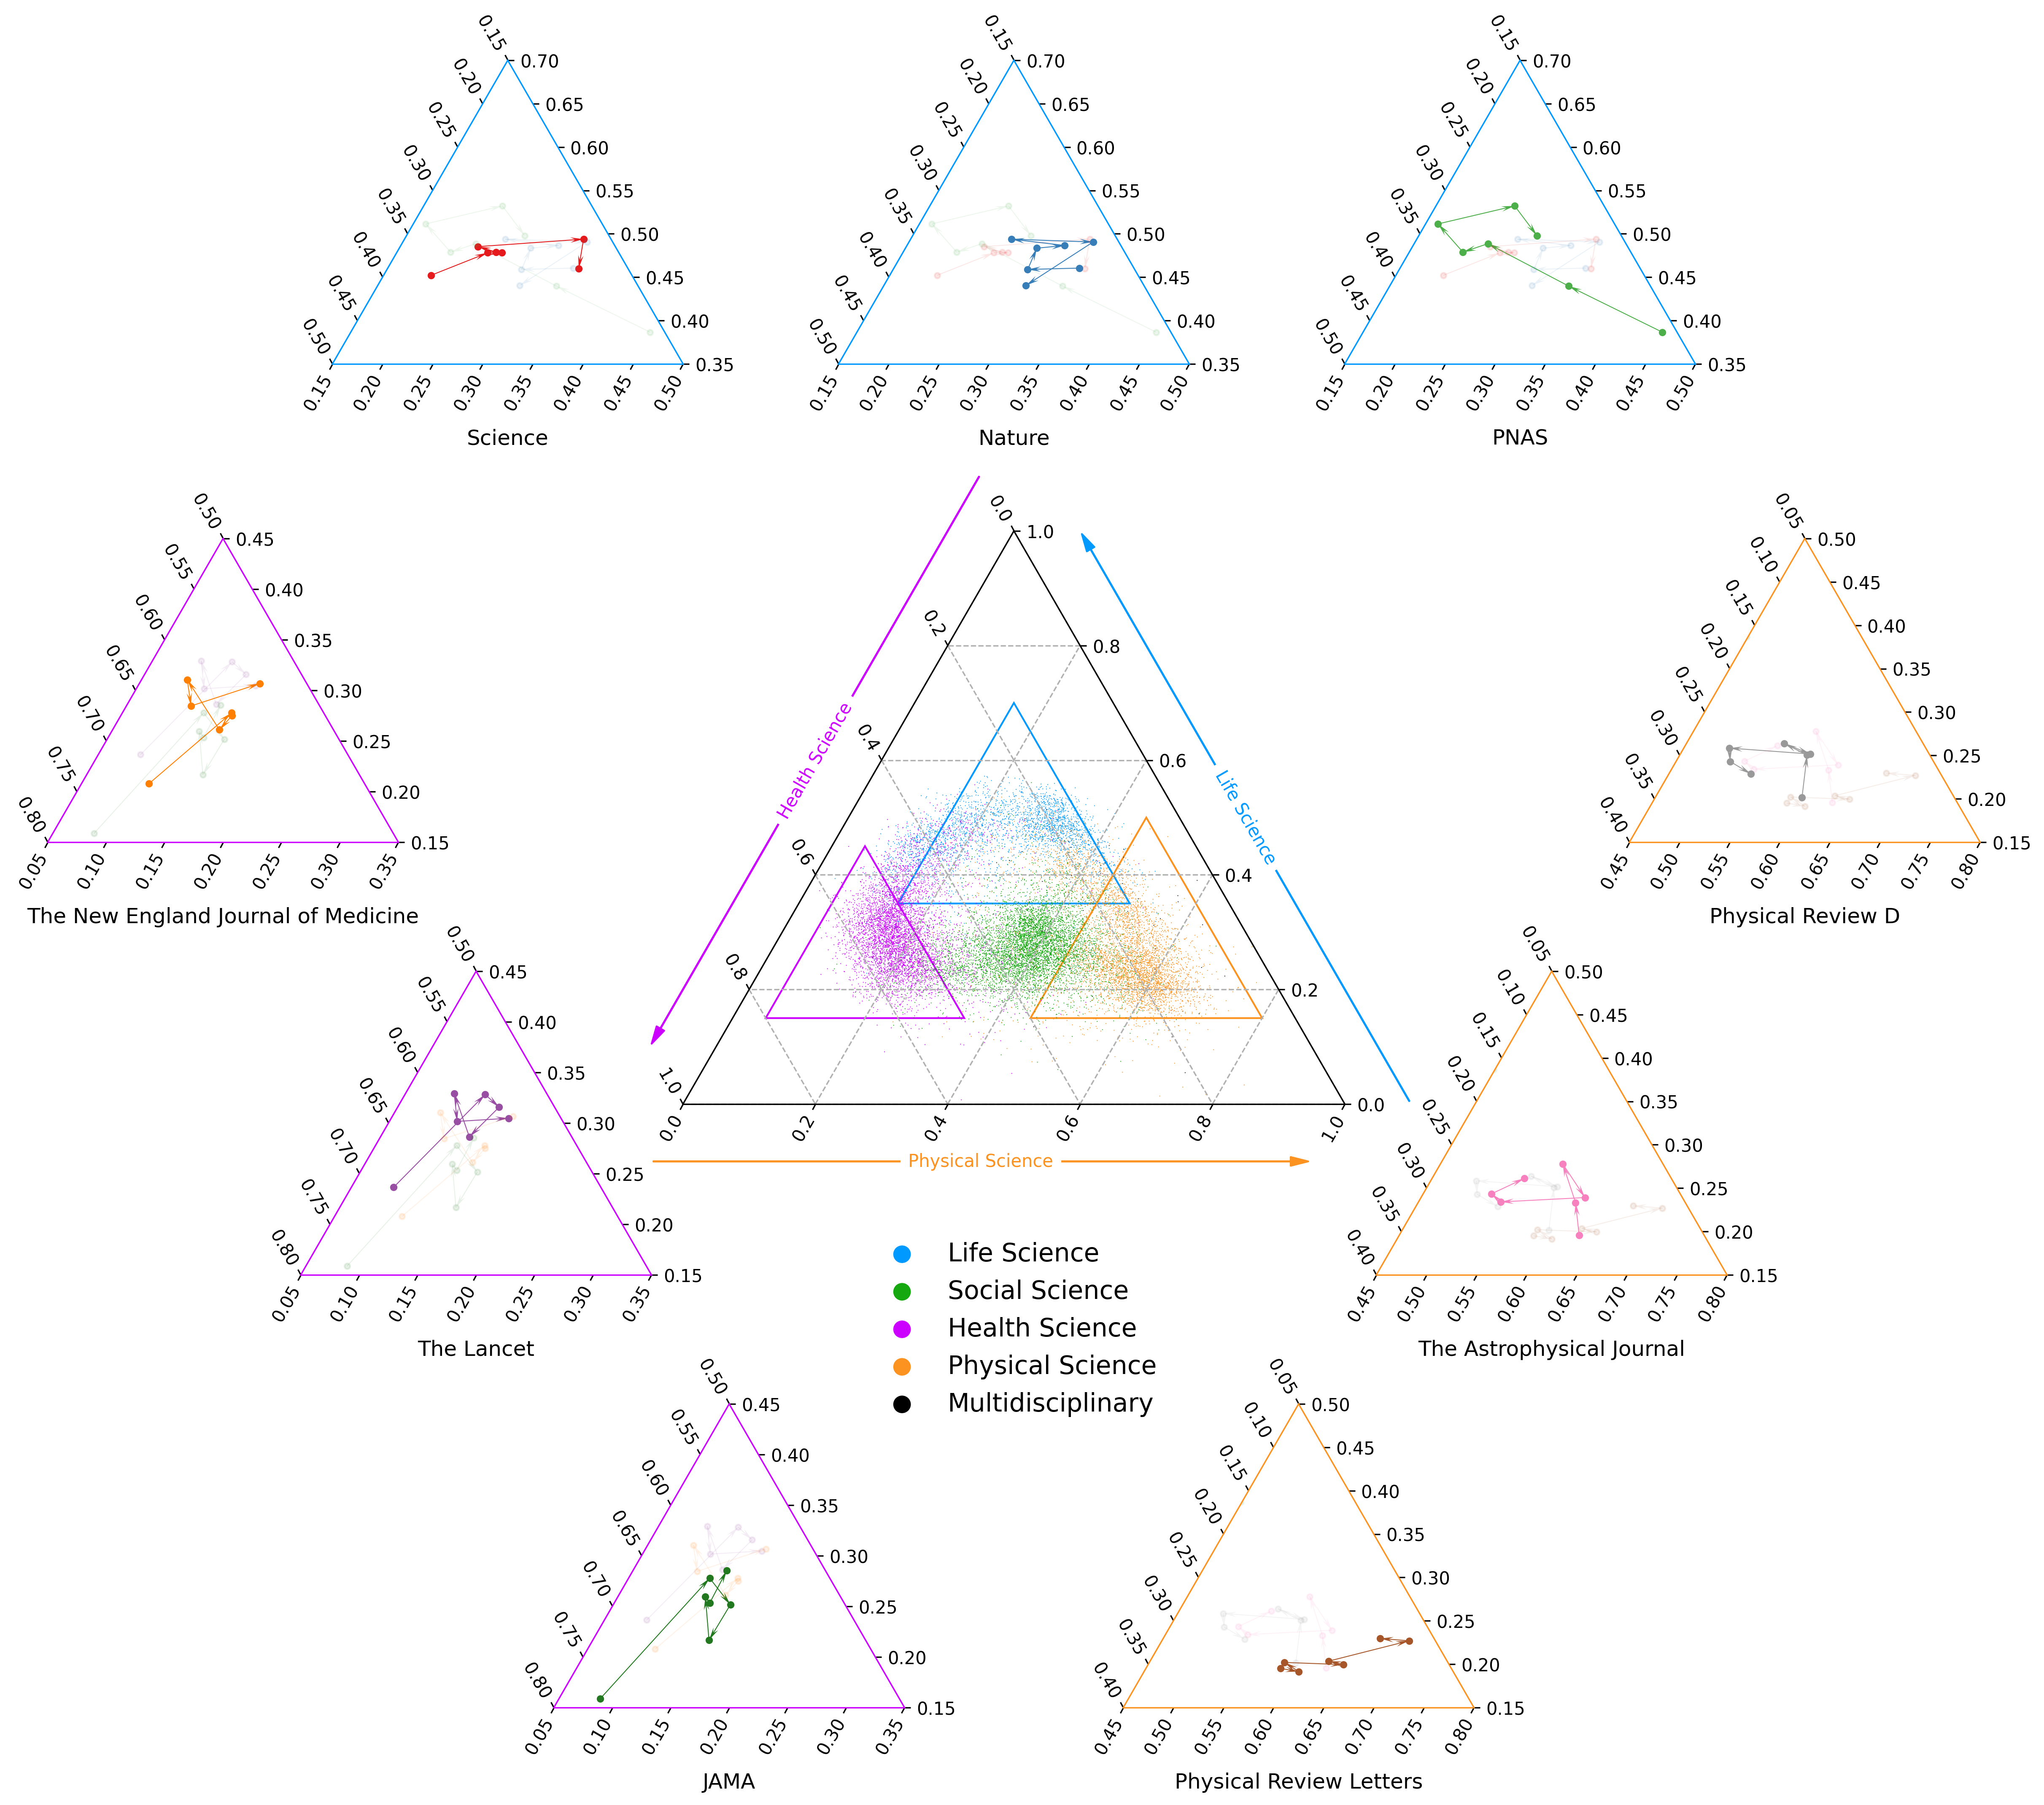

In [8]:
area_color_dict = {'Life Science': '#0099FF',
                   'Health Science': '#CC00FF',
                   'Physical Science': '#FC9320',
                   'Social Science': '#16A90F',
                   'Multidisciplinary': '#000000'}

fig = plt.figure(figsize=(10,6), dpi=300)
fig.subplots_adjust(left=-0.1)
ax = fig.add_subplot(projection='ternary')

ta = np.array([ 0.0, -0.1,  1.1])
la = np.array([ 1.1,  0.0, -0.1])
ra = np.array([-0.1,  1.1,  0.0])

tb = np.array([ 1.0, -0.1,  0.1])
lb = np.array([ 0.1,  1.0, -0.1])
rb = np.array([-0.1,  0.1,  1.0])

f = ax.transAxesProjection.transform

kwargs_arrow = {'transform': ax.transAxes,  # Used with ``ax.transAxesProjection``
                'arrowstyle': arrowstyle,
                'linewidth': 1,
                'clip_on': False,  # To plot arrows outside triangle
                'zorder': -10,  # Very low value not to hide e.g. tick labels.
               }

kwargs_label = {
    'transform': ax.transTernaryAxes,
    'backgroundcolor': 'w',
    'ha': 'center',
    'va': 'center',
    'rotation_mode': 'anchor',
    'zorder': -9,  # A bit higher on arrows, but still lower than others.
}

tarrow = FancyArrowPatch(f(ta), f(tb), ec=life_color, fc=life_color, **kwargs_arrow)
larrow = FancyArrowPatch(f(la), f(lb), ec=health_color, fc=health_color, **kwargs_arrow)
rarrow = FancyArrowPatch(f(ra), f(rb), ec=physical_color, fc=physical_color, **kwargs_arrow)

ax.add_patch(tarrow)
ax.add_patch(larrow)
ax.add_patch(rarrow)

tpos = (ta + tb) * 0.5
lpos = (la + lb) * 0.5
rpos = (ra + rb) * 0.5

ax.text(*tpos, 'Life Science'  , color=life_color, rotation=-60, **kwargs_label)
ax.text(*lpos, 'Health Science' , color=health_color, rotation=60, **kwargs_label)
ax.text(*rpos, 'Physical Science', color=physical_color, rotation=0, **kwargs_label)

ax.grid(linestyle='--')
# ax.taxis.set_major_locator(MultipleLocator(0.05))
# ax.laxis.set_major_locator(MultipleLocator(0.05))
# ax.raxis.set_major_locator(MultipleLocator(0.05))
#------------------------------------------------------------------------#
ax.fill([0.70, 0.35, 0.35], [0.15, 0.50, 0.15], [0.15, 0.15, 0.50], fc="none", ec=life_color)

ax_life_1 = fig.add_axes([-0.2, 1.1, 0.40, 0.40], projection="ternary")
ax_life_1.set_ternary_min(0.35, 0.15, 0.15)
ax_life_1.spines['tside'].set_color(life_color)
ax_life_1.spines['lside'].set_color(life_color)
ax_life_1.spines['rside'].set_color(life_color)

ax_life_2 = fig.add_axes([0.20, 1.1, 0.40, 0.40], projection="ternary")
ax_life_2.set_ternary_min(0.35, 0.15, 0.15)
ax_life_2.spines['tside'].set_color(life_color)
ax_life_2.spines['lside'].set_color(life_color)
ax_life_2.spines['rside'].set_color(life_color)

ax_life_3 = fig.add_axes([0.6, 1.1, 0.40, 0.40], projection="ternary")
ax_life_3.set_ternary_min(0.35, 0.15, 0.15)
ax_life_3.spines['tside'].set_color(life_color)
ax_life_3.spines['lside'].set_color(life_color)
ax_life_3.spines['rside'].set_color(life_color)

ax.fill([0.45, 0.15, 0.15], [0.50, 0.80, 0.50], [0.05, 0.05, 0.35], fc="none", ec=health_color)

ax_health_2 = fig.add_axes([-0.425, 0.47, 0.40, 0.40], projection="ternary")
ax_health_2.set_ternary_min(0.15, 0.50, 0.05)
ax_health_2.spines['tside'].set_color(health_color)
ax_health_2.spines['lside'].set_color(health_color)
ax_health_2.spines['rside'].set_color(health_color)

ax_health_1 = fig.add_axes([-0.225, -0.10, 0.40, 0.40], projection="ternary")
ax_health_1.set_ternary_min(0.15, 0.50, 0.05)
ax_health_1.spines['tside'].set_color(health_color)
ax_health_1.spines['lside'].set_color(health_color)
ax_health_1.spines['rside'].set_color(health_color)

ax_health_3 = fig.add_axes([-0.025, -0.67, 0.40, 0.40], projection="ternary")
ax_health_3.set_ternary_min(0.15, 0.50, 0.05)
ax_health_3.spines['tside'].set_color(health_color)
ax_health_3.spines['lside'].set_color(health_color)
ax_health_3.spines['rside'].set_color(health_color)

ax.fill([0.50, 0.15, 0.15], [0.05, 0.40, 0.05], [0.45, 0.45, 0.80], fc="none", ec=physical_color)

ax_physical_1 = fig.add_axes([0.375, -0.67, 0.50, 0.40], projection="ternary")
ax_physical_1.set_ternary_min(0.15, 0.05, 0.45)
ax_physical_1.spines['tside'].set_color(physical_color)
ax_physical_1.spines['lside'].set_color(physical_color)
ax_physical_1.spines['rside'].set_color(physical_color)

ax_physical_2 = fig.add_axes([0.575, -0.10, 0.50, 0.40], projection="ternary")
ax_physical_2.set_ternary_min(0.15, 0.05, 0.45)
ax_physical_2.spines['tside'].set_color(physical_color)
ax_physical_2.spines['lside'].set_color(physical_color)
ax_physical_2.spines['rside'].set_color(physical_color)

ax_physical_3 = fig.add_axes([0.775, 0.47, 0.50, 0.40], projection="ternary")
ax_physical_3.set_ternary_min(0.15, 0.05, 0.45)
ax_physical_3.spines['tside'].set_color(physical_color)
ax_physical_3.spines['lside'].set_color(physical_color)
ax_physical_3.spines['rside'].set_color(physical_color)

small_ax_list = [ax_life_1, ax_life_2, ax_life_3, 
                 ax_health_1, ax_health_2, ax_health_3, 
                 ax_physical_1, ax_physical_2, ax_physical_3]
#------------------------------------------------------------------------#
i = len(model.start_year_list)-7
start_year, end_year = model.start_year_list[i], model.end_year_list[i]
ternary_df = make_ternary_df(start_year, end_year)

venue_name_list = ['Science',
                   'Nature',
                   'Proceedings of the National Academy of Sciences of the United States of America', 
                   # 'Journal of Biological Chemistry',
                   
                   'The Lancet',
                   'The New England Journal of Medicine',
                   'JAMA',
                   # 'BMJ',
                   
                   'Physical Review Letters', 
                   'The Astrophysical Journal',
                   'Physical Review D'
                   # 'Monthly Notices of the Royal Astronomical Society'
                  ]
color_dict = {'Science': '#e41a1c', 
              'Nature': '#377eb8',
              'Proceedings of the National Academy of Sciences of the United States of America': '#4daf4a',
              # 'Journal of Biological Chemistry': '#984ea3',
              
              'The Lancet': '#984ea3', 
              'The New England Journal of Medicine': '#ff7f00',
              'JAMA': '#21781e',
              # 'BMJ': '#e41a1c',

              'Physical Review Letters': '#a65628', 
              'The Astrophysical Journal': '#f781bf',
              'Physical Review D': '#999999'
              # 'Monthly Notices of the Royal Astronomical Society': ''
             }

tlr_df = pd.DataFrame(columns=['t_list', 'l_list', 'r_list'],
                     index=venue_name_list)

for venue_name in venue_name_list:
    tar_df = ternary_df[ternary_df.venue_name==venue_name]
    tlr_df.loc[venue_name] = [[tar_df.life_cs.values[0]], [tar_df.health_cs.values[0]], [tar_df.physical_cs.values[0]]]

for i in range(len(model.start_year_list)-6, len(model.start_year_list)):
    start_year, end_year = model.start_year_list[i], model.end_year_list[i]
    ternary_df = make_ternary_df(start_year, end_year)

    for venue_name in venue_name_list:
        tar_df = ternary_df[ternary_df.venue_name==venue_name]

        tlr_df.loc[venue_name].t_list.append(tar_df.life_cs.values[0])
        tlr_df.loc[venue_name].l_list.append(tar_df.health_cs.values[0])
        tlr_df.loc[venue_name].r_list.append(tar_df.physical_cs.values[0])
        
        for small_ax in small_ax_list:
            if venue_name_list.index(venue_name) == small_ax_list.index(small_ax):
                alpha=1.0
            else:
                alpha=0.1
            small_ax.quiver(tlr_df.loc[venue_name].t_list[-2], 
            tlr_df.loc[venue_name].l_list[-2], 
            tlr_df.loc[venue_name].r_list[-2], 
            tlr_df.loc[venue_name].t_list[-1] - tlr_df.loc[venue_name].t_list[-2], 
            tlr_df.loc[venue_name].l_list[-1] - tlr_df.loc[venue_name].l_list[-2], 
            tlr_df.loc[venue_name].r_list[-1] - tlr_df.loc[venue_name].r_list[-2],
            angles='xy', scale_units='xy', scale=1, 
            color=color_dict[venue_name], alpha=alpha, 
            width=0.0025, headwidth=6, headlength=15, headaxislength=10)
            
for area in ['Life Science', 'Social Science', 'Health Science', 'Physical Science', 'Multidisciplinary']:
    tar_df = ternary_df[ternary_df.area == area]
    t, l, r = tar_df.life_cs, tar_df.health_cs, tar_df.physical_cs
    ax.scatter(t, l, r, label=area, marker='.', s=1, color=area_color_dict[area], edgecolors='none', alpha=1)

for venue_name in venue_name_list:
    if venue_name == 'Proceedings of the National Academy of Sciences of the United States of America':
        label_name = 'PNAS'
    else: label_name = venue_name

    for small_ax in small_ax_list:
        if venue_name_list.index(venue_name) == small_ax_list.index(small_ax):
            alpha=1.0
            small_ax.set_title(label_name, y=-0.3, fontweight='normal')
        else:
            alpha=0.1
        small_ax.scatter(tlr_df.loc[venue_name].t_list, tlr_df.loc[venue_name].l_list, tlr_df.loc[venue_name].r_list, 
                        s=10, c=color_dict[venue_name], alpha=alpha)
        
ax.legend(markerscale=20, fontsize='x-large', edgecolor='white', bbox_to_anchor=(0.15, -0.8, 0.6, 0.6))
plt.show()

In [ ]:
area_color_dict = {'Life Science': '#0099FF',
                   'Health Science': '#CC00FF',
                   'Physical Science': '#FC9320',
                   'Social Science': '#16A90F',
                   'Multidisciplinary': '#000000'}

fig = plt.figure(figsize=(12,15), dpi=300)
fig.subplots_adjust(left=-0.1)
ax = fig.add_subplot(projection='ternary')

ta = np.array([ 0.0, -0.1,  1.1])
la = np.array([ 1.1,  0.0, -0.1])
ra = np.array([-0.1,  1.1,  0.0])

tb = np.array([ 1.0, -0.1,  0.1])
lb = np.array([ 0.1,  1.0, -0.1])
rb = np.array([-0.1,  0.1,  1.0])

f = ax.transAxesProjection.transform

kwargs_arrow = {'transform': ax.transAxes,  # Used with ``ax.transAxesProjection``
                'arrowstyle': arrowstyle,
                'linewidth': 2,
                'clip_on': False,  # To plot arrows outside triangle
                'zorder': -10,  # Very low value not to hide e.g. tick labels.
               }

kwargs_label = {
    'transform': ax.transTernaryAxes,
    'backgroundcolor': 'w',
    'ha': 'center',
    'va': 'center',
    'rotation_mode': 'anchor',
    'zorder': -9,  # A bit higher on arrows, but still lower than others.
    'fontsize': 'xx-large',
}

tarrow = FancyArrowPatch(f(ta), f(tb), ec=life_color, fc=life_color, **kwargs_arrow)
larrow = FancyArrowPatch(f(la), f(lb), ec=health_color, fc=health_color, **kwargs_arrow)
rarrow = FancyArrowPatch(f(ra), f(rb), ec=physical_color, fc=physical_color, **kwargs_arrow)

ax.add_patch(tarrow)
ax.add_patch(larrow)
ax.add_patch(rarrow)

tpos = (ta + tb) * 0.5
lpos = (la + lb) * 0.5
rpos = (ra + rb) * 0.5

ax.text(*tpos, 'Life Science'  , color=life_color, rotation=-60, **kwargs_label)
ax.text(*lpos, 'Health Science' , color=health_color, rotation=60, **kwargs_label)
ax.text(*rpos, 'Physical Science', color=physical_color, rotation=0, **kwargs_label)

ax.grid(linestyle='--')
# ax.taxis.set_major_locator(MultipleLocator(0.05))
# ax.laxis.set_major_locator(MultipleLocator(0.05))
# ax.raxis.set_major_locator(MultipleLocator(0.05))
#------------------------------------------------------------------------#
# ax.fill([0.70, 0.35, 0.35], [0.15, 0.50, 0.15], [0.15, 0.15, 0.50], fc="none", ec=life_color)

ax_life_1 = fig.add_axes([-0.30, -0.3, 0.40, 0.40], projection="ternary")
ax_life_1.set_ternary_min(0.35, 0.15, 0.15)
ax_life_1.spines['tside'].set_color(life_color)
ax_life_1.spines['lside'].set_color(life_color)
ax_life_1.spines['rside'].set_color(life_color)

ax_life_2 = fig.add_axes([0.20, -0.3, 0.40, 0.40], projection="ternary")
ax_life_2.set_ternary_min(0.35, 0.15, 0.15)
ax_life_2.spines['tside'].set_color(life_color)
ax_life_2.spines['lside'].set_color(life_color)
ax_life_2.spines['rside'].set_color(life_color)

ax_life_3 = fig.add_axes([0.70, -0.3, 0.40, 0.40], projection="ternary")
ax_life_3.set_ternary_min(0.35, 0.15, 0.15)
ax_life_3.spines['tside'].set_color(life_color)
ax_life_3.spines['lside'].set_color(life_color)
ax_life_3.spines['rside'].set_color(life_color)

# ax.fill([0.45, 0.15, 0.15], [0.50, 0.80, 0.50], [0.05, 0.05, 0.35], fc="none", ec=health_color)

ax_health_2 = fig.add_axes([-0.30, -0.7, 0.40, 0.40], projection="ternary")
ax_health_2.set_ternary_min(0.15, 0.50, 0.05)
ax_health_2.spines['tside'].set_color(health_color)
ax_health_2.spines['lside'].set_color(health_color)
ax_health_2.spines['rside'].set_color(health_color)

ax_health_1 = fig.add_axes([0.20, -0.7, 0.40, 0.40], projection="ternary")
ax_health_1.set_ternary_min(0.15, 0.50, 0.05)
ax_health_1.spines['tside'].set_color(health_color)
ax_health_1.spines['lside'].set_color(health_color)
ax_health_1.spines['rside'].set_color(health_color)

ax_health_3 = fig.add_axes([0.70, -0.7, 0.40, 0.40], projection="ternary")
ax_health_3.set_ternary_min(0.15, 0.50, 0.05)
ax_health_3.spines['tside'].set_color(health_color)
ax_health_3.spines['lside'].set_color(health_color)
ax_health_3.spines['rside'].set_color(health_color)

# ax.fill([0.50, 0.15, 0.15], [0.05, 0.40, 0.05], [0.45, 0.45, 0.80], fc="none", ec=physical_color)

ax_physical_1 = fig.add_axes([-0.30, -1.10, 0.40, 0.40], projection="ternary")
ax_physical_1.set_ternary_min(0.15, 0.05, 0.45)
ax_physical_1.spines['tside'].set_color(physical_color)
ax_physical_1.spines['lside'].set_color(physical_color)
ax_physical_1.spines['rside'].set_color(physical_color)

ax_physical_2 = fig.add_axes([0.20, -1.10, 0.40, 0.40], projection="ternary")
ax_physical_2.set_ternary_min(0.15, 0.05, 0.45)
ax_physical_2.spines['tside'].set_color(physical_color)
ax_physical_2.spines['lside'].set_color(physical_color)
ax_physical_2.spines['rside'].set_color(physical_color)

ax_physical_3 = fig.add_axes([0.70, -1.10, 0.40, 0.40], projection="ternary")
ax_physical_3.set_ternary_min(0.15, 0.05, 0.45)
ax_physical_3.spines['tside'].set_color(physical_color)
ax_physical_3.spines['lside'].set_color(physical_color)
ax_physical_3.spines['rside'].set_color(physical_color)

small_ax_list = [ax_life_1, ax_life_2, ax_life_3, 
                 ax_health_1, ax_health_2, ax_health_3, 
                 ax_physical_1, ax_physical_2, ax_physical_3]
#------------------------------------------------------------------------#
i = len(model.start_year_list)-7
start_year, end_year = model.start_year_list[i], model.end_year_list[i]
ternary_df = make_ternary_df(start_year, end_year)

venue_name_list = ['Science',
                   'Nature',
                   'Proceedings of the National Academy of Sciences of the United States of America', 
                   # 'Journal of Biological Chemistry',
                   
                   'The Lancet',
                   'The New England Journal of Medicine',
                   'JAMA',
                   # 'BMJ',
                   
                   'Physical Review Letters', 
                   'The Astrophysical Journal',
                   'Physical Review D'
                   # 'Monthly Notices of the Royal Astronomical Society'
                  ]
color_dict = {'Science': '#0099FF', 
              'Nature': '#0099FF',
              'Proceedings of the National Academy of Sciences of the United States of America': '#0099FF',
              # 'Journal of Biological Chemistry': '#984ea3',
              
              'The Lancet': '#CC00FF', 
              'The New England Journal of Medicine': '#CC00FF',
              'JAMA': '#CC00FF',
              # 'BMJ': '#e41a1c',

              'Physical Review Letters': '#FC9320', 
              'The Astrophysical Journal': '#FC9320',
              'Physical Review D': '#FC9320'
              # 'Monthly Notices of the Royal Astronomical Society': ''
             }

tlr_df = pd.DataFrame(columns=['t_list', 'l_list', 'r_list'],
                     index=venue_name_list)

for venue_name in venue_name_list:
    tar_df = ternary_df[ternary_df.venue_name==venue_name]
    tlr_df.loc[venue_name] = [[tar_df.life_cs.values[0]], [tar_df.health_cs.values[0]], [tar_df.physical_cs.values[0]]]

for i in range(len(model.start_year_list)-6, len(model.start_year_list)):
    start_year, end_year = model.start_year_list[i], model.end_year_list[i]
    ternary_df = make_ternary_df(start_year, end_year)

    for venue_name in venue_name_list:
        tar_df = ternary_df[ternary_df.venue_name==venue_name]

        tlr_df.loc[venue_name].t_list.append(tar_df.life_cs.values[0])
        tlr_df.loc[venue_name].l_list.append(tar_df.health_cs.values[0])
        tlr_df.loc[venue_name].r_list.append(tar_df.physical_cs.values[0])
        
        for small_ax in small_ax_list:
            if venue_name_list.index(venue_name) == small_ax_list.index(small_ax):
                alpha=1.0
            else:
                alpha=0.0
            small_ax.quiver(tlr_df.loc[venue_name].t_list[-2], 
                            tlr_df.loc[venue_name].l_list[-2], 
                            tlr_df.loc[venue_name].r_list[-2], 
                            tlr_df.loc[venue_name].t_list[-1] - tlr_df.loc[venue_name].t_list[-2], 
                            tlr_df.loc[venue_name].l_list[-1] - tlr_df.loc[venue_name].l_list[-2], 
                            tlr_df.loc[venue_name].r_list[-1] - tlr_df.loc[venue_name].r_list[-2],
                            angles='xy', scale_units='xy', scale=1, 
                            color=color_dict[venue_name], alpha=alpha, 
                            width=0.0025, headwidth=6, headlength=15, headaxislength=10)
            
for area in ['Life Science', 'Social Science', 'Health Science', 'Physical Science', 'Multidisciplinary']:
    tar_df = ternary_df[ternary_df.area == area]
    t, l, r = tar_df.life_cs, tar_df.health_cs, tar_df.physical_cs
    ax.scatter(t, l, r, label=area, marker='.', s=10, color=area_color_dict[area], edgecolors='none', alpha=1)

for venue_name in venue_name_list:
    if venue_name == 'Proceedings of the National Academy of Sciences of the United States of America':
        label_name = 'PNAS'
    else: label_name = venue_name

    for small_ax in small_ax_list:
        if venue_name_list.index(venue_name) == small_ax_list.index(small_ax):
            alpha=1.0
            small_ax.set_title(label_name, y=-0.3, fontweight='normal', fontsize='xx-large')
        else:
            alpha=0.0
        small_ax.scatter(tlr_df.loc[venue_name].t_list, tlr_df.loc[venue_name].l_list, tlr_df.loc[venue_name].r_list, 
                        s=15, c=color_dict[venue_name], alpha=alpha)
        
ax.legend(markerscale=15, fontsize='xx-large', edgecolor='white', bbox_to_anchor=(-0.2, 0.9, 0.2, 0.2))
plt.show()

2023-09-16 17:29:35 -- start loading word vectors...
2023-09-16 17:29:35 -- word vectors loaded, and its shape is: (1645, 100)
2023-09-16 17:29:35 -- start loading VID_labeled...
2023-09-16 17:29:35 -- finish.
2023-09-16 17:29:36 -- start loading word vectors...
2023-09-16 17:29:36 -- word vectors loaded, and its shape is: (3116, 100)
2023-09-16 17:29:36 -- start loading VID_labeled...
2023-09-16 17:29:36 -- finish.
2023-09-16 17:29:37 -- start loading word vectors...
2023-09-16 17:29:37 -- word vectors loaded, and its shape is: (5686, 100)
2023-09-16 17:29:37 -- start loading VID_labeled...
2023-09-16 17:29:37 -- finish.
2023-09-16 17:29:39 -- start loading word vectors...
2023-09-16 17:29:39 -- word vectors loaded, and its shape is: (9337, 100)
2023-09-16 17:29:39 -- start loading VID_labeled...
2023-09-16 17:29:39 -- finish.
2023-09-16 17:29:42 -- start loading word vectors...
2023-09-16 17:29:42 -- word vectors loaded, and its shape is: (15019, 100)
2023-09-16 17:29:42 -- start loa

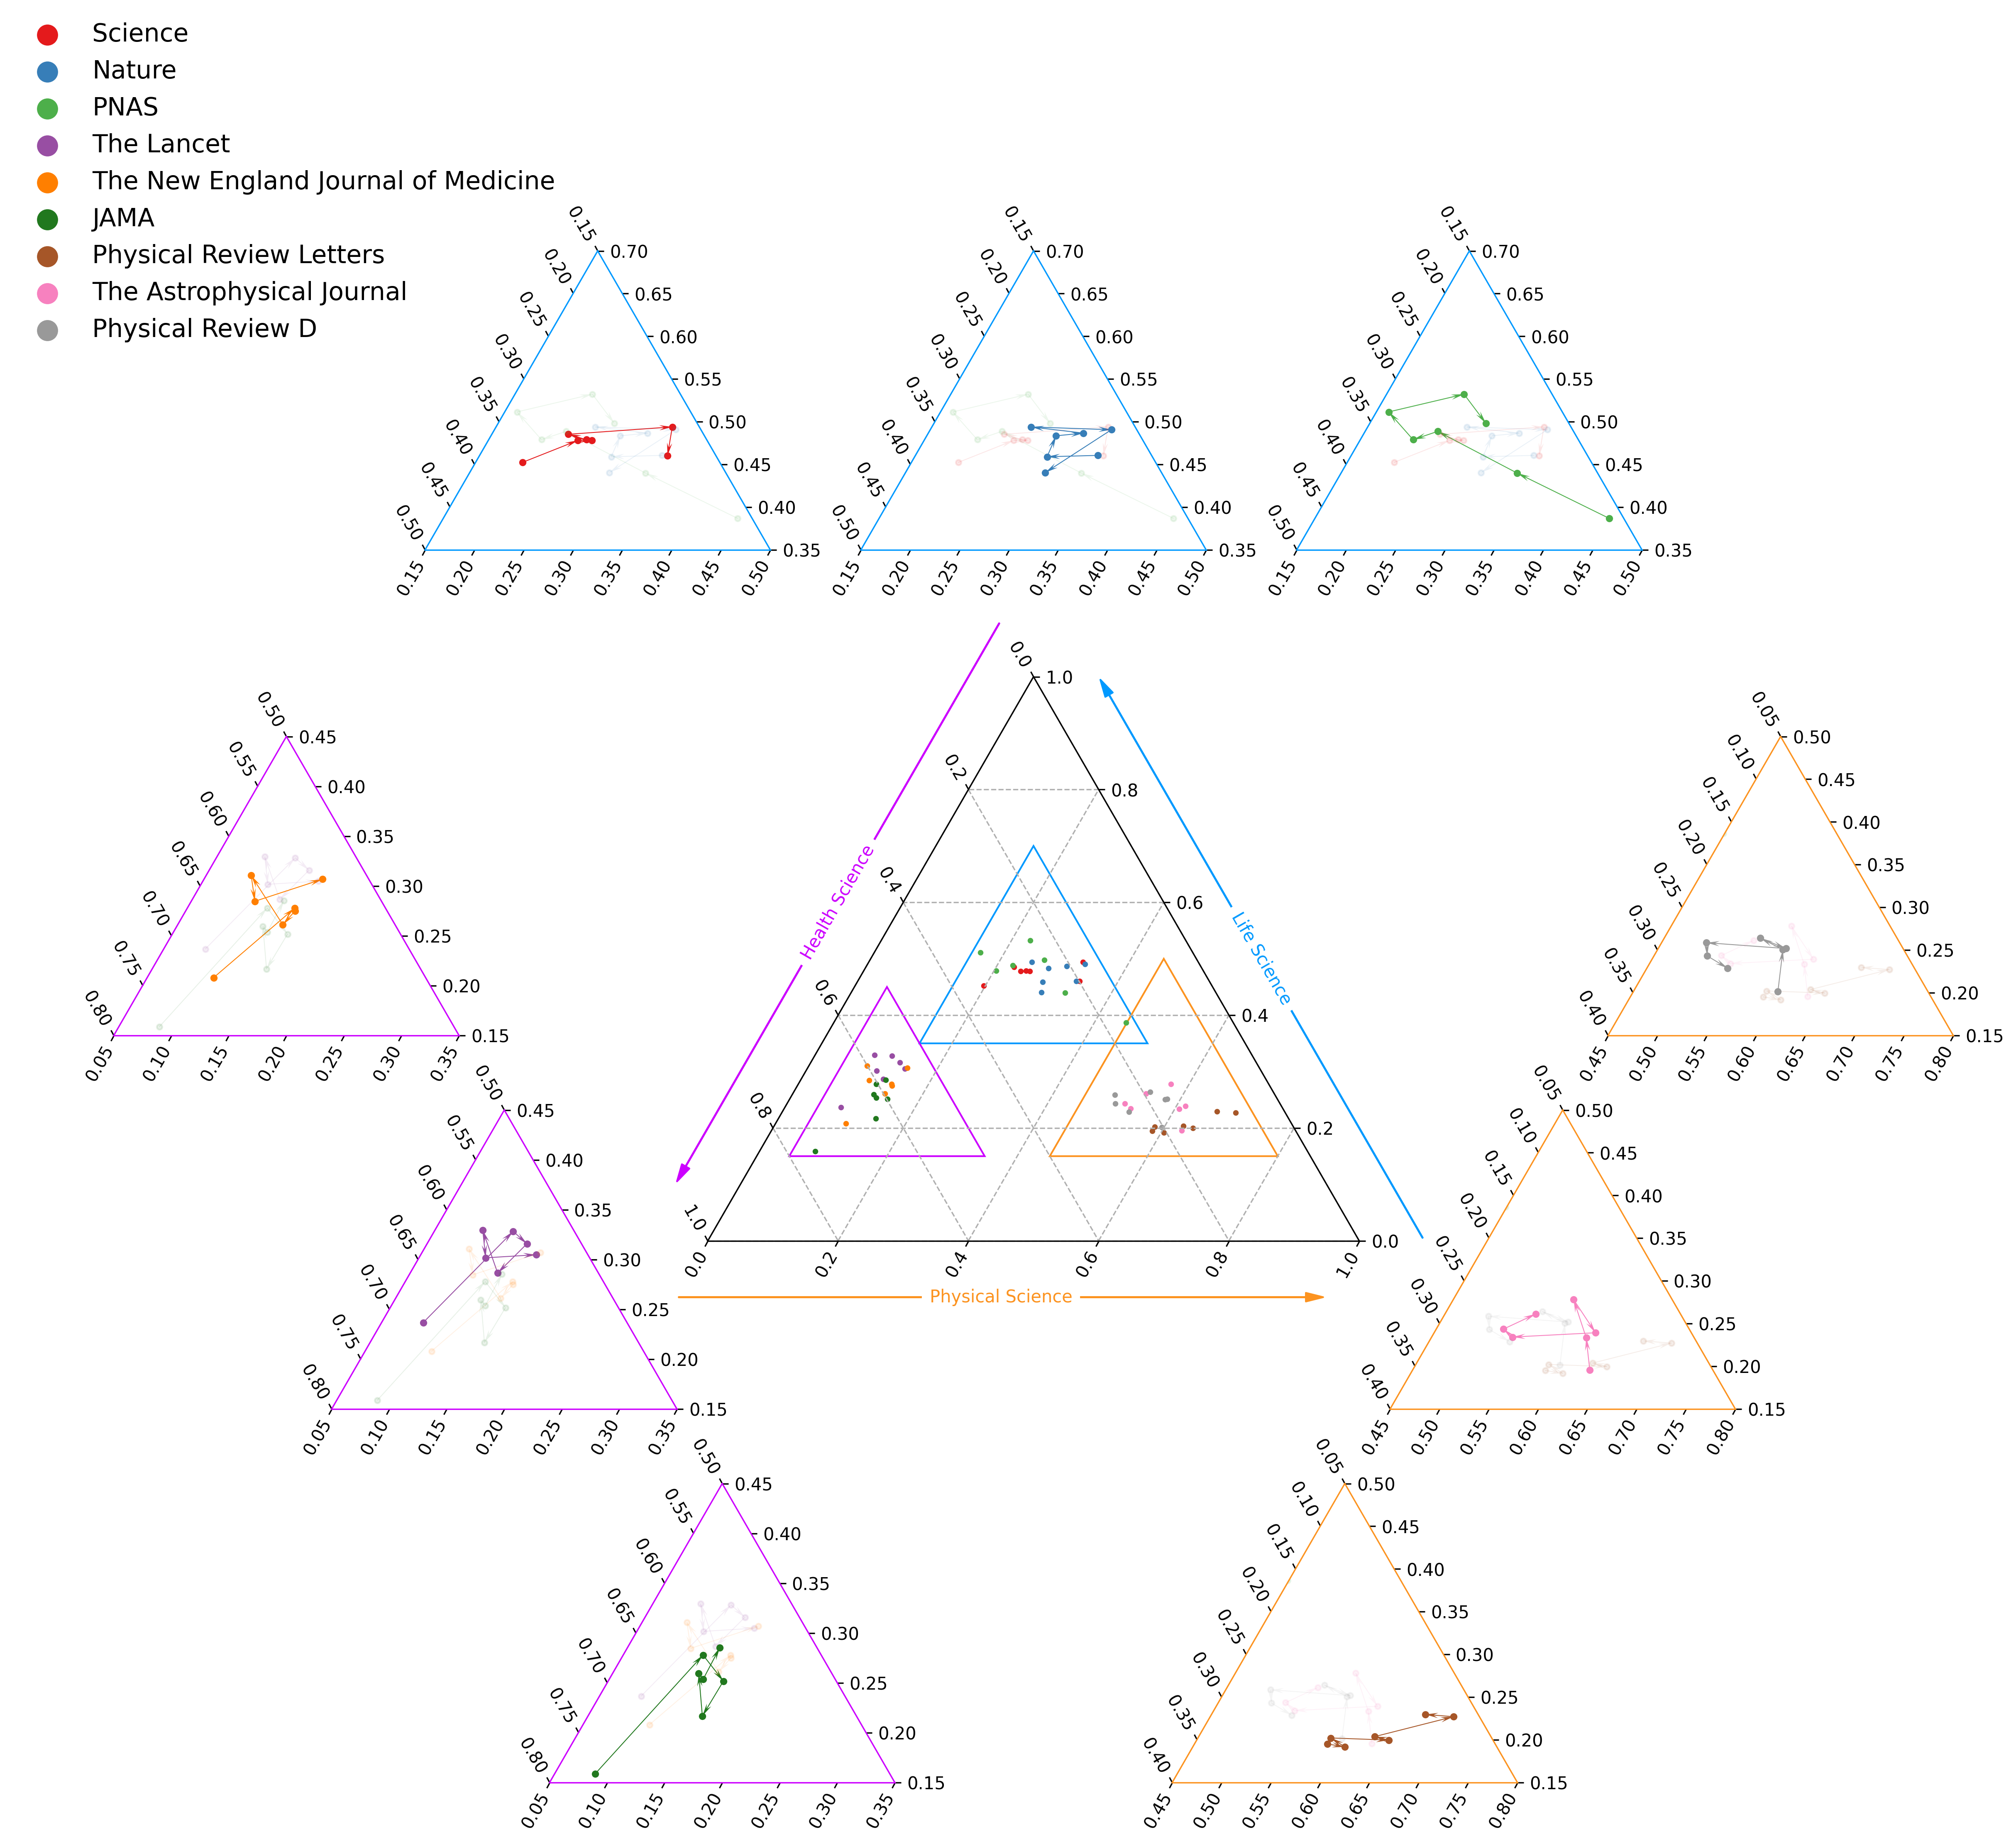

In [160]:
fig = plt.figure(figsize=(10,6), dpi=300)
fig.subplots_adjust(left=-0.1)
ax = fig.add_subplot(projection='ternary')

ta = np.array([ 0.0, -0.1,  1.1])
la = np.array([ 1.1,  0.0, -0.1])
ra = np.array([-0.1,  1.1,  0.0])

tb = np.array([ 1.0, -0.1,  0.1])
lb = np.array([ 0.1,  1.0, -0.1])
rb = np.array([-0.1,  0.1,  1.0])

f = ax.transAxesProjection.transform

kwargs_arrow = {'transform': ax.transAxes,  # Used with ``ax.transAxesProjection``
                'arrowstyle': arrowstyle,
                'linewidth': 1,
                'clip_on': False,  # To plot arrows outside triangle
                'zorder': -10,  # Very low value not to hide e.g. tick labels.
               }

kwargs_label = {
    'transform': ax.transTernaryAxes,
    'backgroundcolor': 'w',
    'ha': 'center',
    'va': 'center',
    'rotation_mode': 'anchor',
    'zorder': -9,  # A bit higher on arrows, but still lower than others.
}

tarrow = FancyArrowPatch(f(ta), f(tb), ec=life_color, fc=life_color, **kwargs_arrow)
larrow = FancyArrowPatch(f(la), f(lb), ec=health_color, fc=health_color, **kwargs_arrow)
rarrow = FancyArrowPatch(f(ra), f(rb), ec=physical_color, fc=physical_color, **kwargs_arrow)

ax.add_patch(tarrow)
ax.add_patch(larrow)
ax.add_patch(rarrow)

tpos = (ta + tb) * 0.5
lpos = (la + lb) * 0.5
rpos = (ra + rb) * 0.5

ax.text(*tpos, 'Life Science'  , color=life_color, rotation=-60, **kwargs_label)
ax.text(*lpos, 'Health Science' , color=health_color, rotation=60, **kwargs_label)
ax.text(*rpos, 'Physical Science', color=physical_color, rotation=0, **kwargs_label)

ax.grid(linestyle='--')
# ax.taxis.set_major_locator(MultipleLocator(0.05))
# ax.laxis.set_major_locator(MultipleLocator(0.05))
# ax.raxis.set_major_locator(MultipleLocator(0.05))
#------------------------------------------------------------------------#
ax.fill([0.70, 0.35, 0.35], [0.15, 0.50, 0.15], [0.15, 0.15, 0.50], fc="none", ec=life_color)

ax_life_1 = fig.add_axes([-0.15, 1.05, 0.40, 0.40], projection="ternary")
ax_life_1.set_ternary_min(0.35, 0.15, 0.15)
ax_life_1.spines['tside'].set_color(life_color)
ax_life_1.spines['lside'].set_color(life_color)
ax_life_1.spines['rside'].set_color(life_color)

ax_life_2 = fig.add_axes([0.20, 1.05, 0.40, 0.40], projection="ternary")
ax_life_2.set_ternary_min(0.35, 0.15, 0.15)
ax_life_2.spines['tside'].set_color(life_color)
ax_life_2.spines['lside'].set_color(life_color)
ax_life_2.spines['rside'].set_color(life_color)

ax_life_3 = fig.add_axes([0.55, 1.05, 0.40, 0.40], projection="ternary")
ax_life_3.set_ternary_min(0.35, 0.15, 0.15)
ax_life_3.spines['tside'].set_color(life_color)
ax_life_3.spines['lside'].set_color(life_color)
ax_life_3.spines['rside'].set_color(life_color)

ax.fill([0.45, 0.15, 0.15], [0.50, 0.80, 0.50], [0.05, 0.05, 0.35], fc="none", ec=health_color)

ax_health_2 = fig.add_axes([-0.400, 0.40, 0.40, 0.40], projection="ternary")
ax_health_2.set_ternary_min(0.15, 0.50, 0.05)
ax_health_2.spines['tside'].set_color(health_color)
ax_health_2.spines['lside'].set_color(health_color)
ax_health_2.spines['rside'].set_color(health_color)

ax_health_1 = fig.add_axes([-0.225, -0.10, 0.40, 0.40], projection="ternary")
ax_health_1.set_ternary_min(0.15, 0.50, 0.05)
ax_health_1.spines['tside'].set_color(health_color)
ax_health_1.spines['lside'].set_color(health_color)
ax_health_1.spines['rside'].set_color(health_color)

ax_health_3 = fig.add_axes([-0.05, -0.60, 0.40, 0.40], projection="ternary")
ax_health_3.set_ternary_min(0.15, 0.50, 0.05)
ax_health_3.spines['tside'].set_color(health_color)
ax_health_3.spines['lside'].set_color(health_color)
ax_health_3.spines['rside'].set_color(health_color)

ax.fill([0.50, 0.15, 0.15], [0.05, 0.40, 0.05], [0.45, 0.45, 0.80], fc="none", ec=physical_color)

ax_physical_1 = fig.add_axes([0.400, -0.60, 0.50, 0.40], projection="ternary")
ax_physical_1.set_ternary_min(0.15, 0.05, 0.45)
ax_physical_1.spines['tside'].set_color(physical_color)
ax_physical_1.spines['lside'].set_color(physical_color)
ax_physical_1.spines['rside'].set_color(physical_color)

ax_physical_2 = fig.add_axes([0.575, -0.10, 0.50, 0.40], projection="ternary")
ax_physical_2.set_ternary_min(0.15, 0.05, 0.45)
ax_physical_2.spines['tside'].set_color(physical_color)
ax_physical_2.spines['lside'].set_color(physical_color)
ax_physical_2.spines['rside'].set_color(physical_color)

ax_physical_3 = fig.add_axes([0.750, 0.40, 0.50, 0.40], projection="ternary")
ax_physical_3.set_ternary_min(0.15, 0.05, 0.45)
ax_physical_3.spines['tside'].set_color(physical_color)
ax_physical_3.spines['lside'].set_color(physical_color)
ax_physical_3.spines['rside'].set_color(physical_color)

small_ax_list = [ax_life_1, ax_life_2, ax_life_3, 
                 ax_health_1, ax_health_2, ax_health_3, 
                 ax_physical_1, ax_physical_2, ax_physical_3]
#------------------------------------------------------------------------#
i = len(model.start_year_list)-7
start_year, end_year = model.start_year_list[i], model.end_year_list[i]
ternary_df = make_ternary_df(start_year, end_year)

venue_name_list = ['Science',
                   'Nature',
                   'Proceedings of the National Academy of Sciences of the United States of America', 
                   # 'Journal of Biological Chemistry',
                   
                   'The Lancet',
                   'The New England Journal of Medicine',
                   'JAMA',
                   # 'BMJ',
                   
                   'Physical Review Letters', 
                   'The Astrophysical Journal',
                   'Physical Review D'
                   # 'Monthly Notices of the Royal Astronomical Society'
                  ]
color_dict = {'Science': '#e41a1c', 
              'Nature': '#377eb8',
              'Proceedings of the National Academy of Sciences of the United States of America': '#4daf4a',
              # 'Journal of Biological Chemistry': '#984ea3',
              
              'The Lancet': '#984ea3', 
              'The New England Journal of Medicine': '#ff7f00',
              'JAMA': '#21781e',
              # 'BMJ': '#e41a1c',

              'Physical Review Letters': '#a65628', 
              'The Astrophysical Journal': '#f781bf',
              'Physical Review D': '#999999'
              # 'Monthly Notices of the Royal Astronomical Society': ''
             }

tlr_df = pd.DataFrame(columns=['t_list', 'l_list', 'r_list'],
                     index=venue_name_list)

for venue_name in venue_name_list:
    tar_df = ternary_df[ternary_df.venue_name==venue_name]
    tlr_df.loc[venue_name] = [[tar_df.life_cs.values[0]], [tar_df.health_cs.values[0]], [tar_df.physical_cs.values[0]]]

for i in range(len(model.start_year_list)-6, len(model.start_year_list)):
    start_year, end_year = model.start_year_list[i], model.end_year_list[i]
    ternary_df = make_ternary_df(start_year, end_year)

    for venue_name in venue_name_list:
        tar_df = ternary_df[ternary_df.venue_name==venue_name]

        tlr_df.loc[venue_name].t_list.append(tar_df.life_cs.values[0])
        tlr_df.loc[venue_name].l_list.append(tar_df.health_cs.values[0])
        tlr_df.loc[venue_name].r_list.append(tar_df.physical_cs.values[0])
        
        for small_ax in small_ax_list:
            if venue_name_list.index(venue_name) == small_ax_list.index(small_ax):
                alpha=1.0
            else:
                alpha=0.1
            small_ax.quiver(tlr_df.loc[venue_name].t_list[-2], 
            tlr_df.loc[venue_name].l_list[-2], 
            tlr_df.loc[venue_name].r_list[-2], 
            tlr_df.loc[venue_name].t_list[-1] - tlr_df.loc[venue_name].t_list[-2], 
            tlr_df.loc[venue_name].l_list[-1] - tlr_df.loc[venue_name].l_list[-2], 
            tlr_df.loc[venue_name].r_list[-1] - tlr_df.loc[venue_name].r_list[-2],
            angles='xy', scale_units='xy', scale=1, 
            color=color_dict[venue_name], alpha=alpha, 
            width=0.0025, headwidth=6, headlength=15, headaxislength=10)

for venue_name in venue_name_list:
    if venue_name == 'Proceedings of the National Academy of Sciences of the United States of America':
        label_name = 'PNAS'
    else: label_name = venue_name
        
    ax.scatter(tlr_df.loc[venue_name].t_list, tlr_df.loc[venue_name].l_list, tlr_df.loc[venue_name].r_list, 
               s=5, c=color_dict[venue_name], label=label_name)

    for small_ax in small_ax_list:
        if venue_name_list.index(venue_name) == small_ax_list.index(small_ax):
            alpha=1.0
        else:
            alpha=0.1
        small_ax.scatter(tlr_df.loc[venue_name].t_list, tlr_df.loc[venue_name].l_list, tlr_df.loc[venue_name].r_list, 
                        s=10, c=color_dict[venue_name], alpha=alpha)

ax.legend(markerscale=5, fontsize='x-large', edgecolor='white', bbox_to_anchor=(-0.80, 1.60, 0.6, 0.6))
plt.show()

In [225]:
dirs = '/media/sdb/p2v/figs/'
if not os.path.exists(dirs):
    os.makedirs(dirs)
fig.savefig('/media/sdb/p2v/figs/ternary_evolution.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

In [197]:
abbr_dict = {
    'Biometrika': 'Biometrika',
    'School Science and Mathematics': 'SSM',
    'The British Journal for the Philosophy of Science': 'Br. J. Philos. Sci. ',
    
    'Analyst': 'Analyst',
    'Photochemistry and Photobiology': 'Photochem. Photobiol',
    'Biotechnology and Bioengineering': 'Biotechnol. Bioeng. ',
    
    'Antonie Van Leeuwenhoek International Journal of General and Molecular Microbiology': 'Antonie Van Leeuwenhoek',
    'Journal of Applied Microbiology': 'J. Appl. Microbiol. ',
    'Critical Reviews in Food Science and Nutrition': 'Crit. Rev. Food Sci. Nutr. ',

    'Theriogenology': 'Theriogenology',
    'Advances in Parasitology': 'J. adv. parasitol. ',
    'Journal of Medical Entomology': 'J. Med. Entomol. ',

    'DNA and Cell Biology': 'DNA Cell Biol.',
    'European Journal of Cell Biology': 'Eur. J. Cell Biol. ',
    'Journal of Molecular Endocrinology': 'J. Mol. Endocrinol. ',

    'Preparative Biochemistry & Biotechnology': 'Prep. Biochem. Biotechnol. ',
    'Methods in Enzymology': 'Meth. Enzymol. ',
    'Asian Journal of Plant Sciences': 'Asian J. Plant Sci. ',

    'European Biophysics Journal': 'Eur. Biophys. J.',
    'Biological Sciences in Space': 'Life Sci. Space Res. ',
    'Lipid Technology': 'Lipid Technol',

    'Nuclear Instruments and Methods': 'Nucl. Instrum. Methods Phys. Res.',
    'Mathematics Magazine': 'Math. Mag.',
    'Acta Metallurgica': 'Acta Metall.',

    'Journal of Optimization Theory and Applications': 'J Optim Theory Appl',
    'IEEE Transactions on Nuclear Science': 'IEEE Trans. Nucl. Sci.',
    'Electronics Letters': 'Electron. Lett.',

    'Physical Review A': 'Phys. Rev. A',
    'Geophysics': 'Geophys. ',
    'Physics': 'Phys. ',

    'Advances in Engineering Software': 'Adv. Eng. Softw.',
    'Reports on Progress in Physics': 'Rep. Prog. Phys. ',
    'International Journal of Solids and Structures': 'Int. J. Solids Struct.',

    'Welding Journal': 'Weld. J.', 
    'Journal of Engineering Mathematics': 'J. Eng. Math.', 
    'Revista Mexicana De Fisica': 'Rev. Mex. de Fis. ',

    'European Physical Journal B': 'Eur. Phys. J. B', 
    'Computer Physics Communications': 'Comput. Phys. Commun.', 
    'Mathematics and Computers in Simulation': 'Math Comput Simul',

    'Energy technology': 'Energy Technol.', 
    'Frontiers in energy': 'Front. Energy', 
    'Progress in Aerospace Sciences': 'Prog. Aerosp. Sci.',

    'Medical Clinics of North America': 'Med. Clin. N. Am.',
    'Postgraduate Medicine': 'Postgrad. Med.',
    'Archives of Disease in Childhood': 'Arch. Dis. Child.',

    'Annals of Internal Medicine': 'Ann. Intern. Med.',
    'JAMA Internal Medicine': 'JAMA Intern. Med.',
    'BMJ': 'BMJ',

    'Annals of Internal Medicine': 'Ann. Intern. Med.',
    'The Journal of Pediatrics': 'J. Pediatr. ',

    'Western Journal of Medicine': 'West. J. Med.',
    
    'Revista Médica del Hospital General de México': 'Rev. Medica del Hosp. Gen. de Mex.',
    
    'The Journal of the American Osteopathic Association': 'J Am Osteopath Assoc',
    'Journal of Obstetrics and Gynaecology': 'J Obstet Gynaecol',
    'International Journal of Pediatrics': 'Int. J. Pediatr.',

    'Clinical Epidemiology': 'Clin. Epidemiol.',
    'The American Journal of Medicine': 'Am. J. Med.',
    'EClinicalMedicine': 'EClinicalMedicine',

    'The New England Journal of Medicine': 'N. Engl. J. Med.',
    'A.M.A. archives of internal medicine': 'AMA Arch. Intern. Med.',

    'The American Journal of Medicine': 'Am. J. Med.',
    'Pediatric Research': 'Pediatr. Res.',

    'Pharmacology & Therapeutics. Part C: Clinical Pharmacology and Therapeutics': 'Clin. Pharmacol. Ther.', 
    'Homeopathy': 'Homeopathy',

    'Expert Opinion on Pharmacotherapy': 'Expert Opin Pharmacother', 
    'European Journal of Internal Medicine': 'Eur. J. Intern. Med.',

    'Acta Clinica Belgica': 'Acta Clin Belg', 
    'Gazi Medical Journal': 'Gazi Medical J.', 
    'European Journal of Obstetrics & Gynecology and Reproductive Biology': 'Eur. J. Obstet. Gynecol. Reprod. Biol.',

    'Case Reports in Oncology': 'Case Rep. Oncol.', 
    'Journal of Global Oncology': 'J. Glob. Oncol.', 
    'Case Reports in Gastroenterology': 'Case Rep. Gastroenterol.' 
}

In [76]:
def cal_tern_dist(x, focal_t, focal_l, focal_r):
    return (x.life_cs - focal_t)**2 + (x.health_cs - focal_l)**2 + (x.physical_cs - focal_r)**2

2023-09-17 12:23:38 -- start loading word vectors...
2023-09-17 12:23:38 -- word vectors loaded, and its shape is: (1645, 100)
2023-09-17 12:23:38 -- start loading VID_labeled...
2023-09-17 12:23:38 -- finish.
['The New England Journal of Medicine', 'Annals of Internal Medicine', 'A.M.A. archives of internal medicine']
['N. Engl. J. Med.', 'Ann. Intern. Med.', 'AMA Arch. Intern. Med.']
2023-09-17 12:23:38 -- start loading word vectors...
2023-09-17 12:23:38 -- word vectors loaded, and its shape is: (3116, 100)
2023-09-17 12:23:38 -- start loading VID_labeled...
2023-09-17 12:23:38 -- finish.
['The American Journal of Medicine', 'Pediatric Research', 'The New England Journal of Medicine']
['Am. J. Med.', 'Pediatr. Res.', 'N. Engl. J. Med.']
2023-09-17 12:23:39 -- start loading word vectors...
2023-09-17 12:23:39 -- word vectors loaded, and its shape is: (5686, 100)
2023-09-17 12:23:39 -- start loading VID_labeled...
2023-09-17 12:23:39 -- finish.
['Pharmacology & Therapeutics. Part C: C

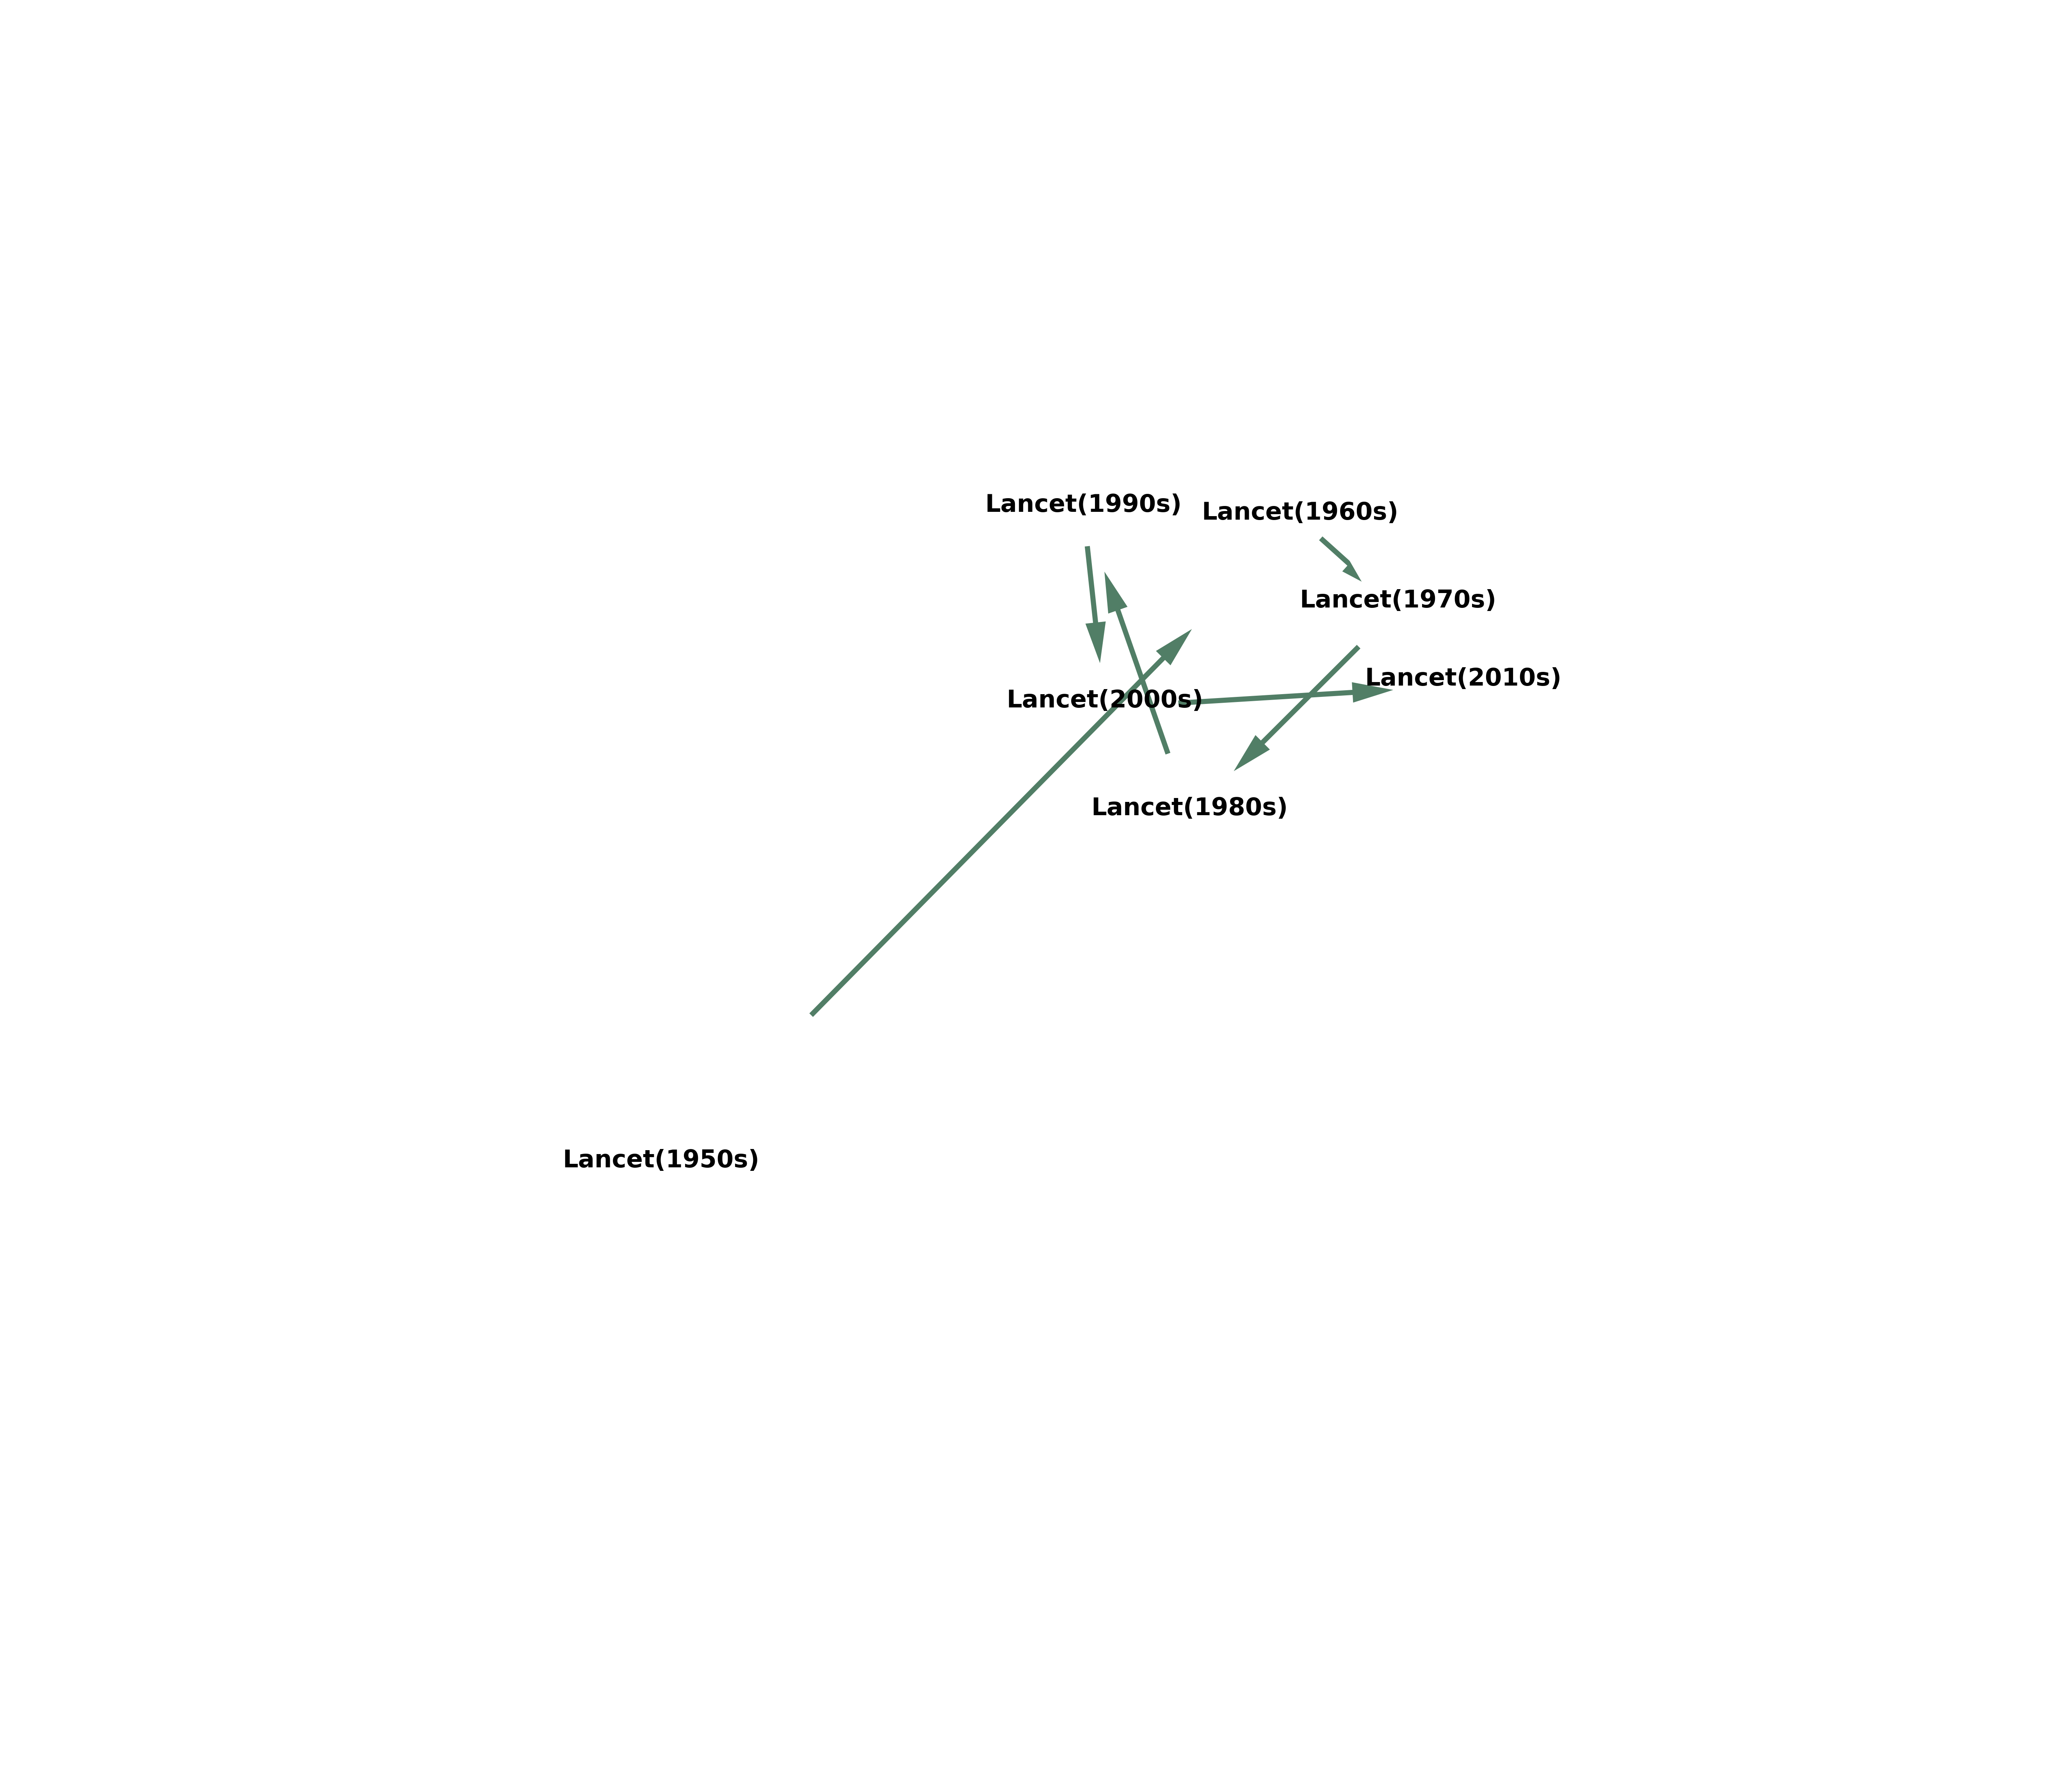

In [198]:
fig = plt.figure(figsize=(20,20), dpi=300)
fig.subplots_adjust(left=-0.1)
ax = fig.add_subplot(projection='ternary')

ax.axis('off')
ax.set_ternary_min(0.15, 0.55, 0.05)

focal_venue_name = 'The Lancet'
focal_abbr = 'Lancet'

focal_t_list = []
focal_l_list = []
focal_r_list = []

i = len(model.start_year_list) - 7
start_year, end_year = model.start_year_list[i], model.end_year_list[i]
ternary_df = make_ternary_df(start_year, end_year)

focal_df = ternary_df[ternary_df.venue_name==focal_venue_name]
focal_t_list.append(focal_df.life_cs.values[0])
focal_l_list.append(focal_df.health_cs.values[0])
focal_r_list.append(focal_df.physical_cs.values[0])

ternary_df.loc[:,'distance'] = ternary_df.apply(cal_tern_dist, 
                                          focal_t=focal_df.life_cs.values[0], 
                                          focal_l=focal_df.health_cs.values[0], 
                                          focal_r=focal_df.physical_cs.values[0], axis=1)
neighbor_list = ternary_df.sort_values('distance')[1:4].venue_name.to_list()
print(neighbor_list)
print([abbr_dict[neighbor] for neighbor in neighbor_list])

text = ax.text(focal_t_list[-1], focal_l_list[-1], focal_r_list[-1],
               focal_abbr + '(%ss)' % model.start_year_list[i], fontsize=15, fontweight='bold', ha='center')

for i in range(len(model.start_year_list)-6, len(model.start_year_list)):
    start_year, end_year = model.start_year_list[i], model.end_year_list[i]
    ternary_df = make_ternary_df(start_year, end_year)

    focal_df = ternary_df[ternary_df.venue_name==focal_venue_name]
    focal_t_list.append(focal_df.life_cs.values[0])
    focal_l_list.append(focal_df.health_cs.values[0])
    focal_r_list.append(focal_df.physical_cs.values[0])

    ax.quiver(focal_t_list[-2] + (focal_t_list[-1] - focal_t_list[-2])*0.2, 
              focal_l_list[-2] + (focal_l_list[-1] - focal_l_list[-2])*0.2, 
              focal_r_list[-2] + (focal_r_list[-1] - focal_r_list[-2])*0.2, 
              (focal_t_list[-1] - focal_t_list[-2])*0.6, 
              (focal_l_list[-1] - focal_l_list[-2])*0.6, 
              (focal_r_list[-1] - focal_r_list[-2])*0.6,
              angles='xy', scale_units='xy', scale=1, 
              color='#517e66', 
              width=0.0025, headwidth=4, headlength=8, headaxislength=8)
    ternary_df.loc[:, 'distance'] = ternary_df.apply(cal_tern_dist, 
                                                     focal_t=focal_df.life_cs.values[0], 
                                                     focal_l=focal_df.health_cs.values[0], 
                                                     focal_r=focal_df.physical_cs.values[0], axis=1)
    neighbor_list = ternary_df.sort_values('distance')[1:4].venue_name.to_list()
    print(neighbor_list)
    print([abbr_dict[neighbor] for neighbor in neighbor_list])

    text = ax.text(focal_t_list[-1], focal_l_list[-1], focal_r_list[-1],
               focal_abbr + '(%ss)' % model.start_year_list[i], fontsize=15, fontweight='bold', ha='center')

plt.show()

In [196]:
dirs = '/media/sdb/p2v/figs/'
if not os.path.exists(dirs):
    os.makedirs(dirs)
fig.savefig('/media/sdb/p2v/figs/Lancet_evolution.pdf', 
            dpi = 300, 
            transparent=True, 
            bbox_inches='tight')